In [1]:
# -*- coding: utf-8 -*- #

import os
from time import time

# Write libraries here #########################################
import astropy.io.fits as iofits
import matplotlib.patches as pat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table
from astroquery.gama import GAMA
from jupyterthemes import jtplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, manifold, mixture, preprocessing
from tqdm import tnrange, tqdm_notebook

%matplotlib inline
# %matplotlib notebook
################################################################


# Showing 500 columns and rows #################################
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
################################################################


# NOT CHANGE (The PATH for directory) ##########################
CURRENT_DIR_NAME = os.path.dirname(os.path.abspath(__name__))
PATH_DATA = os.path.join(CURRENT_DIR_NAME, '../data/')
PATH_HIST = os.path.join(CURRENT_DIR_NAME, '../histogram/')
PATH_PLOT = os.path.join(CURRENT_DIR_NAME, '../plots/')
PATH_IMG = os.path.join(CURRENT_DIR_NAME, '../images/')
PATH_HTML = os.path.join(CURRENT_DIR_NAME, '../html/')
PATH_TEX = os.path.join(CURRENT_DIR_NAME, '../for_tex/')
################################################################

#When you make plots, jtplot is better.
jtplot.style(theme='grade3', context='notebook', fscale=3, spines=True, gridlines='--', ticks=False, grid=False)
plt.style.use('dark_background')


In [2]:
table = Table.read(PATH_DATA + 'rcsed.fits')
DATA_SDSS_FLUX = table.to_pandas()
DATA_SDSS_FLUX = DATA_SDSS_FLUX.query('zconf >= 0.5')
DATA_SDSS_FLUX.describe()

,objid,specobjid,mjd,plate,fiberid,ra,dec,z,zerr,zconf,petror50_r,e_bv,specclass,corrmag_fuv,corrmag_nuv,corrmag_u,corrmag_g,corrmag_r,corrmag_i,corrmag_z,corrmag_y,corrmag_j,corrmag_h,corrmag_k,corrmag_fuv_err,corrmag_nuv_err,corrmag_u_err,corrmag_g_err,corrmag_r_err,corrmag_i_err,corrmag_z_err,corrmag_y_err,corrmag_j_err,corrmag_h_err,corrmag_k_err,kcorr_fuv,kcorr_nuv,kcorr_u,kcorr_g,kcorr_r,kcorr_i,kcorr_z,kcorr_y,kcorr_j,kcorr_h,kcorr_k,ssp_radvel,ssp_radvel_err,ssp_veldisp,ssp_veldisp_err,ssp_age,ssp_age_err,ssp_met,ssp_met_err,ssp_chi2,exp_radvel,exp_radvel_err,exp_veldisp,exp_veldisp_err,exp_tau,exp_tau_err,exp_met,exp_met_err,exp_chi2,zy_offset,spectrum_snr
count,7.986580e+05,7.986580e+05,798658.000000,798658.000000,798658.000000,798658.000000,798658.000000,798658.000000,798658.000000,798658.000000,798576.000000,485224.000000,798658.0,286140.000000,468799.000000,798236.000000,798563.000000,798617.000000,798560.000000,798578.000000,270222.000000,265012.000000,271691.000000,272766.000000,286106.000000,468799.000000,795789.000000,798074.000000,798424.000000,798475.000000,798320.000000,270270.000000,265062.000000,271736.000000,272810.000000,286103.000000,468758.000000,796919.000000,798037.000000,798117.000000,798307.000000,798029.000000,266382.000000,261403.000000,270519.000000,261434.000000,798636.000000,798636.000000,798636.000000,798636.000000,798636.000000,798636.000000,798636.000000,798636.000000,798636.000000,798647.000000,798647.000000,798647.000000,798647.000000,798647.000000,798647.000000,798647.000000,798647.000000,798647.000000,280216.000000,798645.000000
mean,5.878151e+17,4.127710e+17,53078.048391,1465.647343,320.314267,185.039106,24.944092,0.141192,0.000162,0.982951,2.479668,0.031452,2.0,20.537298,20.546692,19.745617,18.159468,17.251192,16.849827,16.612860,16.109922,15.950429,15.654301,15.695339,0.219568,0.185071,0.430968,0.059158,0.040112,0.038552,0.066772,0.031122,0.031720,0.035759,0.038650,-0.011740,0.083665,0.417911,0.355978,0.124224,0.044759,0.029174,0.035717,-0.055684,-0.025071,-0.257391,42323.625000,33.596565,167.668671,34.438099,8121.427246,976.651184,-0.212952,0.124370,0.688198,42321.714844,20.919117,163.497330,23.179455,5922.536621,485.058716,-0.203505,0.094510,0.691879,-0.420814,13.952522
std,5.018406e+14,2.072006e+17,814.859120,736.112485,184.144191,59.022819,18.924761,0.102740,0.004615,0.043208,1.242016,0.020084,0.0,1.224883,1.440617,1.632507,1.205827,0.940510,0.896952,0.908128,0.913776,0.958861,0.925785,0.888111,0.144353,0.153533,0.989335,0.275451,0.232136,0.208300,0.196632,0.024346,0.024951,0.028125,0.029105,0.107757,0.167848,0.713829,0.450206,0.212784,0.158347,0.130116,0.210729,0.182453,0.105021,0.180015,30799.304688,125.689903,89.809685,125.844292,6058.460449,1154.572754,0.338759,0.090600,0.324084,30812.107422,85.670830,84.505287,90.003525,7072.353027,1334.521118,0.327091,0.114091,0.262384,18.925522,6.837354
min,5.877230e+17,7.509409e+16,51608.000000,266.000000,1.000000,0.001715,-11.252832,0.007000,0.000000,0.500019,0.092404,0.002847,2.0,14.436873,13.963811,11.601770,11.664032,10.761065,10.935957,10.020756,10.044827,9.345041,8.635180,8.741549,0.001616,0.000762,0.004241,0.001093,0.000909,0.000801,0.001474,0.000454,0.000418,0.000369,0.000570,-5.280943,-0.254345,-9.992208,-9.982695,-9.887530,-9.918608,-9.901817,-9.797421,-9.956815,-8.791143,-9.149771,-38.802536,-0.000000,6.902977,-0.000000,1.000000,-0.000000,-2.291030,0.000000,0.227978,-354.765198,-0.000000,6.902977,-0.000000,10.000000,-0.000000,-2.491690,-0.000000,0.308235,-7.344272,0.053174
25%,5.877321e+17,2.324414e+17,52373.000000,825.000000,161.000000,150.748667,9.745508,0.073498,0.000126,0.987138,1.729948,0.018157,2.0,19.763903,19.540134,18.856443,17.532553,16.806810,16.434044,16.186712,15.670677,15.476692,15.205114,15.261204,0.119894,0.070641,0.100305,0.013052,0.010471,0.011502,0.027874,0.016121,0.016301,0.017676,0.020335,-0.034673,-0.013871,0.129553,0.085902,0.034945,-0.012141,-0.000457,0.007309,-0.077339,-0.029210,-0.325473,22030.294922,

In [3]:
# Band list for K-correction
BANDS = {'fuv', 'nuv', 'u', 'g', 'r', 'i', 'z', 'y', 'j', 'h', 'k'}

Notes (Conversion formula for apparent and absolute AB magnitude)

${\rm m}_{\rm AB,\,band} = {\rm M}_{\rm AB,\,band} + 5\log\left(\frac{D_L}{10\,[{\rm pc}]}\right) + K_{\rm band}$ ($D_L$ : Luminosity Distance)

$\left({\rm m}_{\rm AB,\,band} = -2.5\log\left(\frac{f_{\rm band}}{[{\rm Jy}]}\right) + 8.90\right)$

In [4]:
def MakeKcorrected(band):
    """
    This function for calculating absolute magnitude for each galaxy considering K-correnction.
    DATA_SDSS_FLUX['"BAND"_flux_kcorrected'] shows absolute magnitude at each band.
    """
    lum_dist_pc = cosmo.luminosity_distance(DATA_SDSS_FLUX['z']).to(u.parsec).value
    k_correction = DATA_SDSS_FLUX['kcorr_%s' % (band)]
    DATA_SDSS_FLUX['kcorrected_%s' % (band)] = DATA_SDSS_FLUX['corrmag_%s' % (band)] - k_correction - 5 * np.log10(lum_dist_pc / 10)

In [5]:
# Append K-corrected absolute magnitude to the DATA_SDSS_FLUX
for band in tqdm_notebook(BANDS):
    MakeKcorrected(band)
    
# Define colors R-k and NUV-R
DATA_SDSS_FLUX['R-K'] = DATA_SDSS_FLUX['kcorrected_r'] - DATA_SDSS_FLUX['kcorrected_k']
DATA_SDSS_FLUX['NUV-R'] = DATA_SDSS_FLUX['kcorrected_nuv'] - DATA_SDSS_FLUX['kcorrected_r']

## Show the distribution of redshift of our samples

# of samples = 798658


Text(0.5, 1.0, 'The redshift distribution of samples')

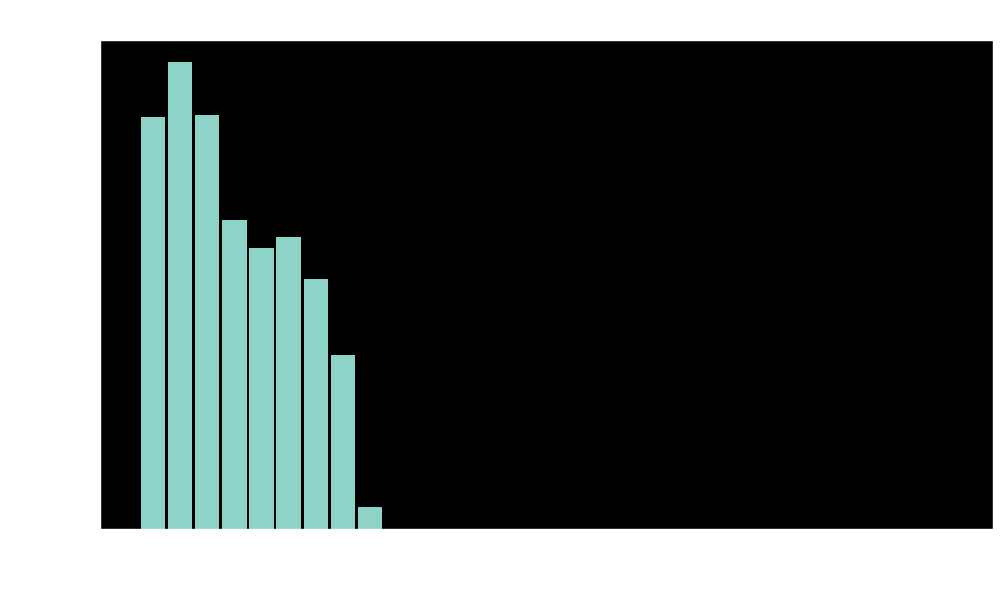

In [6]:
plt.figure(figsize=(16, 9))
plt.hist(DATA_SDSS_FLUX['z'], range=[0, 2], bins=30,  rwidth=0.9)
print('# of samples = %s'%(len(DATA_SDSS_FLUX['z'])))
plt.xlabel('Redshift')
plt.ylabel('Number')
plt.yscale('log')
plt.title('The redshift distribution of samples')

/home/syoshida/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/syoshida/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


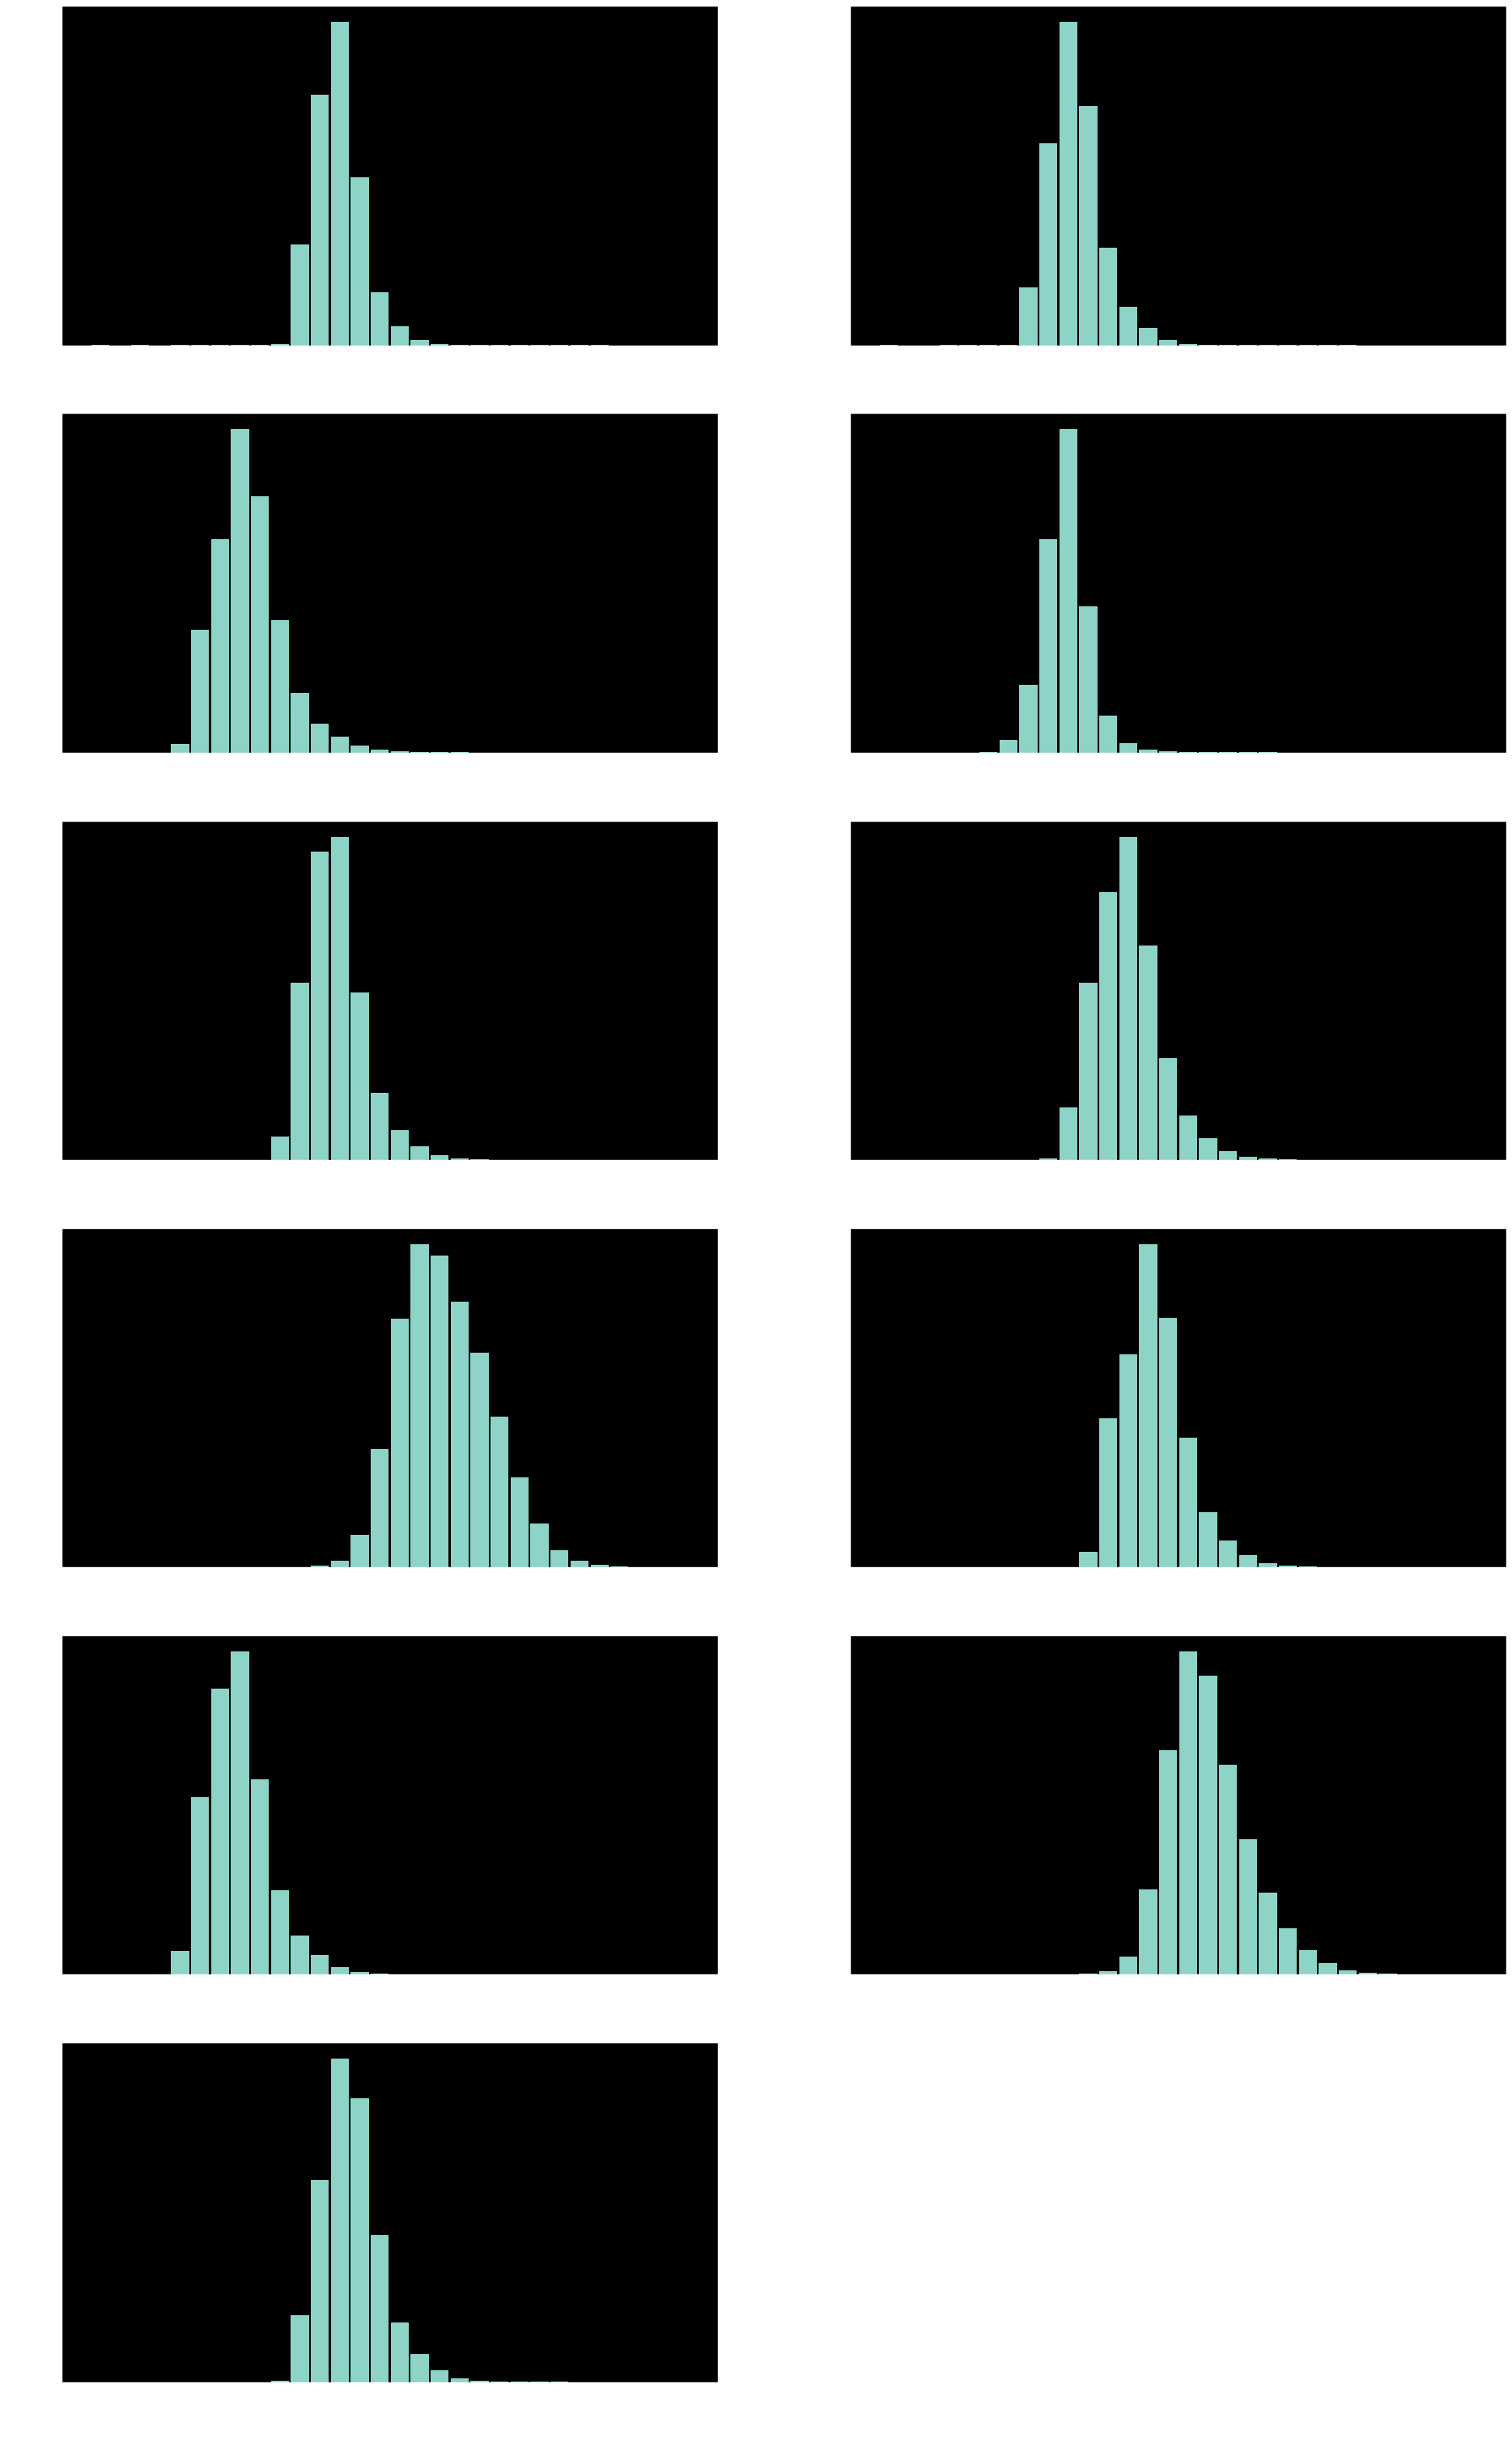

In [7]:
fig = plt.figure(figsize=(32, 54))
for i, band in tqdm_notebook(enumerate(BANDS)):
    ax = fig.add_subplot(6, 2, 1+i)
    ax.hist(DATA_SDSS_FLUX['kcorrected_%s'%(band)], density=True, bins=30,  rwidth=0.9)
    ax.set_xlabel(r'$M_{AB, %s-band}$'%(band))

(-1, 8)

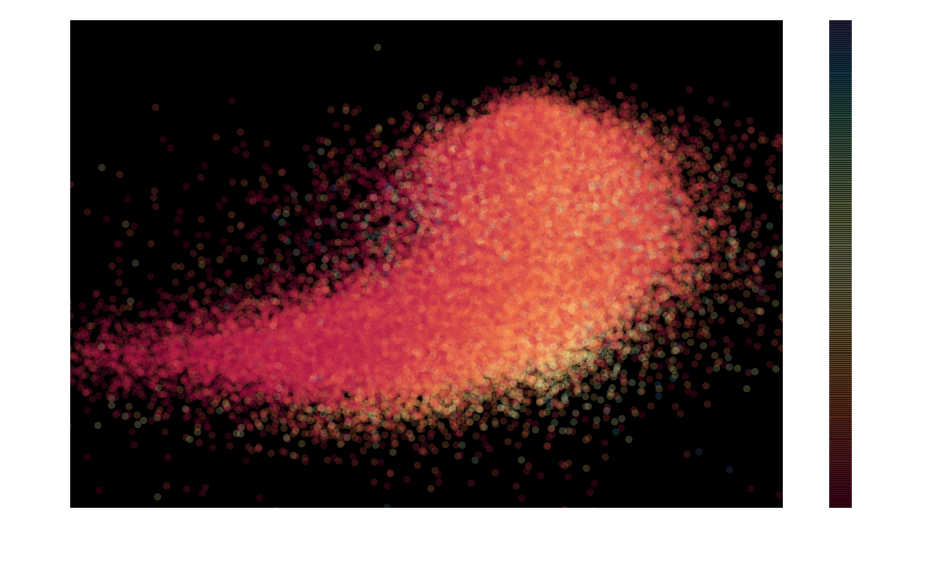

In [8]:
# Show the color-color plot with labels (each number on the plot shows the label number)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
x = DATA_SDSS_FLUX['R-K']
y = DATA_SDSS_FLUX['NUV-R']
c_z = DATA_SDSS_FLUX['z']
plt.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Redshift')
plt.xlabel('r-K')
plt.xlim([-1, 2.5])
plt.ylabel('NUV-r')
plt.ylim([-1, 8])

In [9]:
# Select columns for classification and manifold learning
data_for_manifoldlearning = DATA_SDSS_FLUX[['z', 'kcorrected_fuv', 'kcorrected_nuv',
                                            'kcorrected_u', 'kcorrected_g', 'kcorrected_r', 'kcorrected_i', 'kcorrected_z',
                                            'kcorrected_y', 'kcorrected_j', 'kcorrected_h', 'kcorrected_k']].dropna()

In [ ]:
X = data_for_manifoldlearning

# RobustScaler uses [0.25, 0.75] samples
sc=preprocessing.StandardScaler()
#sc=preprocessing.RobustScaler()
sc.fit(X)
X_norm=sc.transform(X)

plt.figure(figsize=(10,10))
x=X_norm[:,0]
y=X_norm[:,1]

#Execute the K-means
km=cluster.KMeans(n_clusters=15)
z_km=km.fit(X_norm)

# Plot the K-means result
plt.subplot(311)
plt.scatter(x,y, c=z_km.labels_)
plt.scatter(z_km.cluster_centers_[:,0],z_km.cluster_centers_[:,1],s=250, marker='*',c='red')

# Execute the VBGMM
vbgm = mixture.BayesianGaussianMixture(n_components=15, covariance_type='full', max_iter=1000, verbose=1)
vbgm=vbgm.fit(X_norm)
labels=vbgm.predict(X_norm)

# Plot the VBGMM result
plt.subplot(312)
plt.scatter(x,y, c=labels)

# Plot the probability distribution calculated by VBGMM
#print(vbgm.weights_)
plt.subplot(313)
x_tick =np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.bar(x_tick, vbgm.weights_, width=0.7, tick_label=x_tick)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
  Iteration 240
  Iteration 250
  Iteration 260
  Iteration 270
  Iteration 280
  Iteration 290
  Iteration 300
  Iteration 310
  Iteration 320
  Iteration 330
  Iteration 340
  Iteration 350
  Iteration 360
  Iteration 370
  Iteration 380
  Iteration 390
  Iteration 400
  Iteration 410
  Iteration 420
  Iteration 430
  Iteration 440
  Iteration 450
  Iteration 460
  Iteration 470
  Iteration 480
  Iteration 490
  Iteration 500
  Iteration 510
  Iteration 520
  Iteration 530
  Iteration 540
  Iteration 550
  Iteration 560
  Iteration 570
  Iteration 580
  Iteration 590
  Iteration 600
  Iteration 610
  Iteration 620


In [ ]:
# Add the label from VBGMM to the original pd.DataFrame
data_for_manifoldlearning_plus_label = data_for_manifoldlearning.join(pd.DataFrame(labels, index=data_for_manifoldlearning.index, columns=['label']))
DATA_SDSS_FLUX = DATA_SDSS_FLUX.join(pd.DataFrame(labels, index=data_for_manifoldlearning.index, columns=['label']))

In [ ]:
# Show the color-color plot with labels (each number on the plot shows the label number)

plt.figure(figsize=(16, 9))
x = DATA_SDSS_FLUX['R-K']
y = DATA_SDSS_FLUX['NUV-R']
plt.scatter(x, y, c=DATA_SDSS_FLUX['label'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Label')
plt.clim(vmin=0, vmax=14)
plt.xlabel('r-K')
plt.xlim([-1, 2.5])
plt.ylabel('NUV-r')
plt.ylim([-1, 8])

for i in tnrange(15):
    x_mean = np.mean(DATA_SDSS_FLUX.loc[DATA_SDSS_FLUX['label'] == i, 'R-K'])
    y_mean = np.mean(DATA_SDSS_FLUX.loc[DATA_SDSS_FLUX['label'] == i, 'NUV-R'])
    print('label:%s, center_point=(%s, %s)'%(i, x_mean, y_mean))
    print('# of samples : %s'%(len(DATA_SDSS_FLUX.loc[DATA_SDSS_FLUX['label'] == i])))
    plt.text(x_mean, y_mean, '$%s$'%(i), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_SDSS_FLUX.loc[DATA_SDSS_FLUX['label'] == i])/200, color=plt.cm.Spectral(i/14))
    

In [ ]:
#  Color-color plot with colorbars based on redshift
fig = plt.figure(figsize=(32, 36))
for i in tnrange(6):
    if i <= 4:
        ax = fig.add_subplot(421+i)
        z_range = (DATA_SDSS_FLUX['z'] >= 0.1 * i) & (DATA_SDSS_FLUX['z'] < (0.1 * i) + 0.1)
        x = DATA_SDSS_FLUX['R-K'].loc[z_range]
        y = DATA_SDSS_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_SDSS_FLUX['label'].loc[z_range]
        ax.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral)
        ax.set_xlabel('r-K')
        ax.set_xlim([-1, 2.5])
        ax.set_ylabel('NUV-r')
        ax.set_ylim([-1, 8])
        ax.set_title(r'Color-color plot [%s $\leq z$ < %s]'%('{:.1f}'.format((0.1 * i)), '{:.1f}'.format((0.1 * i) + 0.1)))
        for j in range(15):
            x_mean = np.mean(DATA_SDSS_FLUX.loc[z_range & (DATA_SDSS_FLUX['label'] == j), 'R-K'])
            x_std = np.std(DATA_SDSS_FLUX.loc[z_range & (DATA_SDSS_FLUX['label'] == j), 'R-K'])
            y_mean = np.mean(DATA_SDSS_FLUX.loc[z_range & (DATA_SDSS_FLUX['label'] == j), 'NUV-R'])
            y_std = np.std(DATA_SDSS_FLUX.loc[z_range & (DATA_SDSS_FLUX['label'] == j), 'NUV-R'])
            #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
            #print('# of samples : %s'%(len(DATA_SDSS_FLUX.loc[z_range & (DATA_SDSS_FLUX['label'] == j)])))
            if not np.isnan(x_mean):
                e1 =pat.Ellipse(xy = (x_mean, y_mean), width = x_std, height = y_std, alpha = 0.6, angle = 0, color =plt.cm.Spectral(j/14))
                ax.add_patch(e1)
    else:
        ax = fig.add_subplot(421+i)
        z_range = (DATA_SDSS_FLUX['z'] >= 0.1 * i)
        x = DATA_SDSS_FLUX['R-K'].loc[z_range]
        y = DATA_SDSS_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_SDSS_FLUX['label'].loc[z_range]
        ax.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral)
        ax.set_xlabel('r-K')
        ax.set_xlim([-1, 2.5])
        ax.set_ylabel('NUV-r')
        ax.set_ylim([-1, 8])
        ax.set_title(r'Color-color plot [%s $\leq z$]'%('{:.1f}'.format(0.1 * i)))
        for j in range(15):
            x_mean = np.mean(DATA_SDSS_FLUX.loc[z_range & (DATA_SDSS_FLUX['label'] == j), 'R-K'])
            x_std = np.std(DATA_SDSS_FLUX.loc[z_range & (DATA_SDSS_FLUX['label'] == j), 'R-K'])
            y_mean = np.mean(DATA_SDSS_FLUX.loc[z_range & (DATA_SDSS_FLUX['label'] == j), 'NUV-R'])
            y_std = np.std(DATA_SDSS_FLUX.loc[z_range & (DATA_SDSS_FLUX['label'] == j), 'NUV-R'])
            #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
            #print('# of samples : %s'%(len(DATA_SDSS_FLUX.loc[z_range & (DATA_SDSS_FLUX['label'] == j)])))
            if not np.isnan(x_mean):
                e1 =pat.Ellipse(xy = (x_mean, y_mean), width = x_std, height = y_std, alpha = 0.6, angle = 0, color =plt.cm.Spectral(j/14))
                ax.add_patch(e1)

ax = fig.add_subplot(427)
x = DATA_SDSS_FLUX['R-K']
y = DATA_SDSS_FLUX['NUV-R']
ax.scatter(x, y, c=DATA_SDSS_FLUX['label'], alpha=0.2, cmap=plt.cm.Spectral)
ax.set_xlabel('r-K')
ax.set_xlim([-1, 2.5])
ax.set_ylabel('NUV-r')
ax.set_ylim([-1, 8])
ax.set_title('Color-color plot for all samples')
for j in range(15):
    x_mean = np.mean(DATA_SDSS_FLUX.loc[(DATA_SDSS_FLUX['label'] == j), 'R-K'])
    x_std = np.std(DATA_SDSS_FLUX.loc[(DATA_SDSS_FLUX['label'] == j), 'R-K'])
    y_mean = np.mean(DATA_SDSS_FLUX.loc[(DATA_SDSS_FLUX['label'] == j), 'NUV-R'])
    y_std = np.std(DATA_SDSS_FLUX.loc[(DATA_SDSS_FLUX['label'] == j), 'NUV-R'])
    if not np.isnan(x_mean):
        e1 =pat.Ellipse(xy = (x_mean, y_mean), width = x_std, height = y_std, alpha = 0.8, angle = 0, color =plt.cm.Spectral(j/14))
        ax.add_patch(e1)
        
plt.subplot(428)
x = DATA_SDSS_FLUX['R-K']
y = DATA_SDSS_FLUX['NUV-R']
plt.scatter(x, y, c=DATA_SDSS_FLUX['label'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Label')
plt.clim(vmin=0, vmax=15)
plt.xlabel('r-K')
plt.xlim([-1, 2.5])
plt.ylabel('NUV-r')
plt.ylim([-1, 8])
plt.title('Color-color plot for all samples')
for j in range(15):
    x_mean = np.mean(DATA_SDSS_FLUX.loc[(DATA_SDSS_FLUX['label'] == j), 'R-K'])
    x_std = np.std(DATA_SDSS_FLUX.loc[(DATA_SDSS_FLUX['label'] == j), 'R-K'])
    y_mean = np.mean(DATA_SDSS_FLUX.loc[(DATA_SDSS_FLUX['label'] == j), 'NUV-R'])
    y_std = np.std(DATA_SDSS_FLUX.loc[(DATA_SDSS_FLUX['label'] == j), 'NUV-R'])
    #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
    #print('# of samples : %s'%(len(DATA_SDSS_FLUX.loc[z_range & (DATA_SDSS_FLUX['label'] == j)])))
    if not np.isnan(x_mean):
        plt.text(x_mean, y_mean, '$%s$'%(j), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_SDSS_FLUX.loc[(DATA_SDSS_FLUX['label'] == j)])/200, color=plt.cm.Spectral(j/14))
        plt.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='.', lw=5)
plt.tight_layout()

In [ ]:
# Output DATA_SDSS_FLUX as pickle file
DATA_SDSS_FLUX.to_pickle(PATH_DATA + 'SDSSDataForManifold.pickle')

Pickle file is read by Python faster than csv file.

When you import pickle file "df = pd.read_pickle(PATH_DATA + 'GAMADataForManifold.pickle')".